In [1]:
import numpy as np

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import PDHG_2013 as PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter, Binner

# Import CIL utilities
from cil.utilities.display import show2D
from cil.utilities import dataexample

# Import from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator


# Import FBP from CIL recon class
from cil.recon import FBP, FDK

from cil.framework import ImageData

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from cil.io import TIFFStackReader, TIFFWriter
from cil.framework import AcquisitionData, AcquisitionGeometry
import numpy as np
import os
import warnings


processed_data_path="/mnt/share-private/rasmia_preprocessed/preprocessed_data"


def read_processed_data(exposure_time, num_angles):
    """
    Reads processed data from TIFF files and a comma-separated angles file.

    Parameters
    ----------
    - exposure_time (float, int): The exposure time in seconds
    - num_angles (int): The number of angles

    Returns
    -------
    - data (cil AcquisitionData): The processed projection data read from the TIFF files.
    """

    # convert exposure_time to string with '.' replaced with '_'
    exposure_time_str = str(exposure_time).replace('.', '_')
    # To update later:
    file_path = os.path.join(processed_data_path, f'exp_{exposure_time_str}_angles_{num_angles}')

    # Define paths for each type of data
    angles_file = os.path.join(file_path, f'angles_{exposure_time_str}.csv')

    mi_file = os.path.join(file_path, 'image.json')


    # Read angles from the CSV file
    angles = []
    with open(angles_file, "r") as csvfile:
        for line in csvfile:
            angles.append(float(line.strip()))
    if len(angles) != num_angles:
        raise ValueError(f"Number of angles in file ({len(angles)}) does not match expected number ({num_angles})")
    
    # Read projection data using TIFFStackReader
    proj_reader = TIFFStackReader(file_name=file_path)
    data = proj_reader.read()

    import json

    # Read the JSON file
    with open(mi_file, "r") as jsonfile:
        d= json.load(jsonfile)
        # Extract last cor_tilt_finding
        final_cor_tilt = None
        for op in reversed(d["operation_history"]):
            if op["name"] == "cor_tilt_finding":
                final_cor_tilt = op["kwargs"]
                break

    rotation_centre = final_cor_tilt['rotation_centre']
    tilt_angle_deg = final_cor_tilt['tilt_angle_deg']
    

    
    offset = -rotation_centre + data.shape[2] / 2
    pixel_size=48*10**-4
    offset = offset + np.tan(tilt_angle_deg * np.pi / 180) * (data.shape[1] / 2)
    # print(f"Offset: {offset*pixel_size}, Tilt angle (deg): {tilt_angle_deg}")
    # print(f"Expected: offset={-8.235721150709189*pixel_size}, angle=-0.002745552568811436)")

    pixel_size=48*10**-4

    acquisition_geometry = AcquisitionGeometry.create_Parallel3D().set_panel(num_pixels=[ data.shape[2], data.shape[1]], pixel_size = [pixel_size, pixel_size]).set_angles(angles=angles)
    ac_data = AcquisitionData(data, geometry=acquisition_geometry)

    ac_data.geometry.set_centre_of_rotation(-offset*pixel_size, angle=-tilt_angle_deg, angle_units='degree')

    from cil.processors import TransmissionAbsorptionConverter
    ac_data = TransmissionAbsorptionConverter()(ac_data)
    return ac_data


absorption = read_processed_data(60, 840)


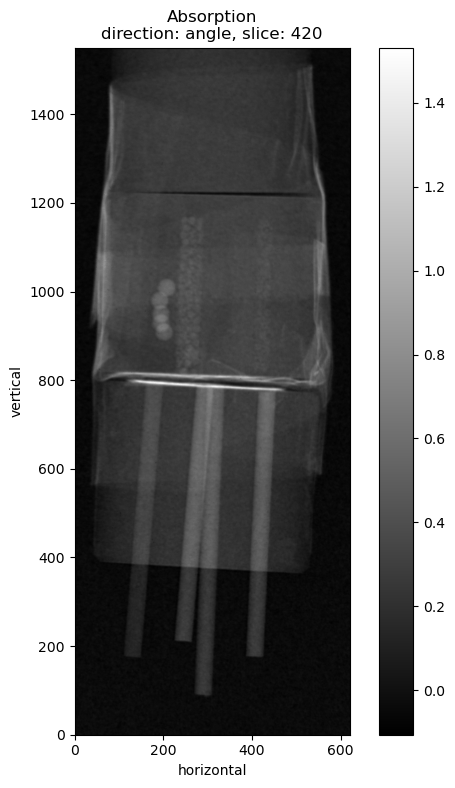

In [3]:
show2D(absorption, title='Absorption', cmap='gray')

In [4]:
from cil.optimisation.utilities.callbacks import Callback, ProgressCallback

class SaveStepSizes(Callback):
    def __init__(self):
        super().__init__()
        self.tau = []
        self.sigma = []

    def __call__(self, algorithm):
        self.tau.append(algorithm.tau)
        self.sigma.append(algorithm.sigma)      

In [5]:
absorption = Binner(roi = {'horizontal':(None,None,2),'vertical':(None,None,2), 'vertical':(None,None,2)})(absorption)
ig=absorption.geometry.get_ImageGeometry()
print(ig)

ig.voxel_num_x = 140
ig.voxel_num_y = 140
ig.voxel_num_z = 70
ig.voxel_size_x = 2*ig.voxel_size_x
ig.voxel_size_y = 2*ig.voxel_size_y
ig.voxel_size_z = 2*ig.voxel_size_z
ig.center_z = - 40*ig.voxel_size_z
ig.center_y = - 5*ig.voxel_size_y
ig.center_x = + 5*ig.voxel_size_x
print(ig)


New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0.04098219, 0.        , 0.        ]
	Rotation axis direction: [0.00281955, 0.        , 0.99999603]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [310 775]
	Pixel size: [0.0096 0.0096]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 840
	Angles 0-9 in degrees: [0.   , 0.429, 0.858, 1.287, 1.716, 2.145, 2.574, 3.003, 3.432, 3.861]
	Angles 830-839 in degrees: [356.07 , 356.499, 356.928, 357.357, 357.786, 358.215, 358.644, 359.073,
 359.502, 359.931]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (840, 775, 310)
New geometry shape:  (840, 775, 310)
Number of channels: 1
channel_spacing: 1.0
voxel_num : x310,y310,z775
voxel_size : x

In [6]:
from cil.plugins.astra import FBP
absorption.reorder('astra')
fbp = FBP(ig, absorption.geometry)
fbp.set_input(absorption)
reconstruction = fbp.get_output()




In [7]:
from cil.utilities.jupyter import islicer
islicer(reconstruction)

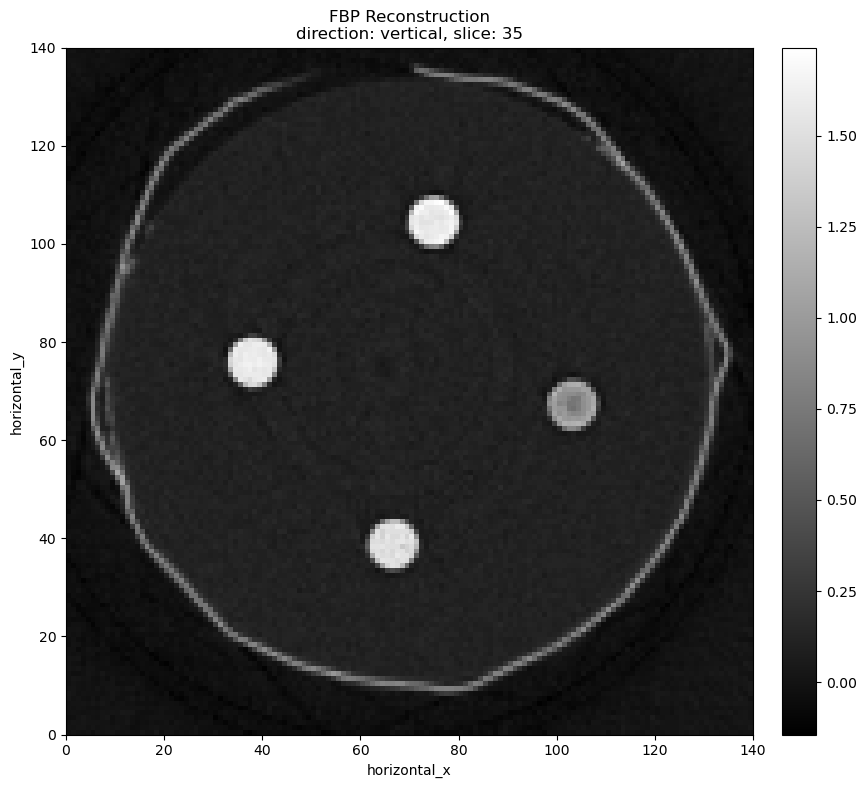

1.7948574


In [8]:
show2D(reconstruction, title='FBP Reconstruction', cmap='gray')
print(np.max(reconstruction.as_array()))

In [9]:

A = ProjectionOperator(ig, absorption.geometry, device = "gpu")

#  PDHG with implicit TV regularisation - adaptive vs non-adaptive - changing step size values 

In [10]:
# F = 0.5 * L2NormSquared(b=absorption)
# alpha = 0.5
# G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
# rho = 1.0

# step_size_list = [  1/A.norm(), 0.01, 0.1, 1, 10, 100, 1000]
# results_adaptive = []
# objective_adaptive = []
# sigma_values = []
# tau_values = []
# for step_size in step_size_list:
#     print("sigma and tau = ", step_size)
#     sigma = step_size
#     tau = step_size
#     pdhg_tv_explicit = PDHG(initial = [recon, A.direct(recon)/A.norm()], f = F, g = G, operator = A,
#                 update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)
#     callback=SaveStepSizes()
#     pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
#     results_adaptive.append(pdhg_tv_explicit.solution)
#     objective_adaptive.append(pdhg_tv_explicit.objective)
#     sigma_values.append(callback.sigma)
#     tau_values.append(callback.tau)
    

In [11]:
# plt.figure()
# for i, step_size in enumerate(step_size_list):
#     plt.plot(range(0, 201, 1), objective_adaptive[i], label='step_size = ' + str(step_size))
# plt.yscale('log')
# plt.xlabel('Iteration')
# plt.ylabel('Objective value')
# plt.legend()
# plt.show()

# plt.figure()
# for i, step_size in enumerate(step_size_list):
#     plt.plot(range(0, 201, 1), sigma_values[i], label='step_size = ' + str(step_size))
# plt.title('Sigma values over iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Sigma value')
# plt.yscale('log')
# plt.legend()
# plt.show()

# plt.figure()
# for i, step_size in enumerate(step_size_list):
#     plt.plot(range(0, 201, 1), tau_values[i], label='step_size = ' + str(step_size))
# plt.title('Tau values over iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Tau value')
# plt.yscale('log')
# plt.legend()
# plt.show()

# plt.figure()
# for i, step_size in enumerate(step_size_list):
#     #plt the ratio of sigma to tau
#     plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='step_size = ' + str(step_size))
# plt.title('Ratio of Sigma to Tau values over iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Sigma/Tau value')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [12]:
# F = 0.5 * L2NormSquared(b=absorption)
# alpha = 0.5
# G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
# rho = 1.0

# step_size_list = [  1/A.norm(), 0.01, 0.1, 1, 10, 100, 1000]
# results_vanilla = []
# objective_vanilla = []
# for step_size in step_size_list:
#     print("sigma and tau = ", step_size)
#     sigma = step_size
#     tau = step_size
#     pdhg_tv_explicit = PDHG(f = F, g = G, operator = A,
#                 update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=False)
#     pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback()])
#     results_vanilla.append(pdhg_tv_explicit.solution)
#     objective_vanilla.append(pdhg_tv_explicit.objective)


In [13]:
# for i, step_size in enumerate(step_size_list):
#     plt.plot(range(0, 201, 1), objective_vanilla[i], label='step_size = ' + str(step_size))
#     plt.plot(range(0, 201, 1), objective_adaptive[i], label='step_size = ' + str(step_size)+' adaptive', linestyle='dashed')
# plt.yscale('log')
# plt.xlabel('Iteration')
# plt.ylabel('Objective value')
# plt.legend()
# plt.show()

#  PDHG with implicit TV regularisation - adaptive vs non-adaptive - changing gamma 

In [14]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list =  [ 100, 1000,  1/A.norm(), 0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_implicit.run(50, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_implicit.solution)
    objective_adaptive.append(pdhg_tv_implicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

gamma =  100
Initial step sizes: tau = 0.000774563136687595, sigma = 7.7456313668759496


  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  14.020116
x norm =  14.011003
After possible reduction 0.000774563136687595 7.7456313668759496
2*self.d_norm < self.p_norm
After adaptive 0.015491262733751886 0.38728156834379784 0.9025
x_tmp norm =  284.73273
x norm =  270.53406
After possible reduction 0.015491262733751886 0.38728156834379784
2*self.p_norm < self.d_norm
After adaptive 0.0015103981165408094 3.9721186496799765 0.8573749999999999
x_tmp norm =  205.82288
x norm =  80.539536
After possible reduction 0.0015103981165408094 3.9721186496799765
2*self.d_norm < self.p_norm
After adaptive 0.01058999555856833 0.566523422410607 0.8145062499999999
x_tmp norm =  170.48273
x norm =  201.49283
x_change_norm = 201.49282836914062, y_change_norm = 1499.1201171875, ((self.gamma*self.sigma)*x_change_norm**2 + (self.gamma*self.tau)*y_change_norm**2)= 42120.029384579306, cross_term = 45954.05600812132
Multiplying step sizes by beta/b, beta = 0.75, b = 1.091026209610046
Recomputing x and y after reducing step sizes
After possibl

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  1.5628409
x norm =  1.5619274
After possible reduction 7.74563136687595e-05 77.45631366875949
2*self.d_norm < self.p_norm
After adaptive 0.0015491262733751887 3.872815683437978 0.9025
x_tmp norm =  32.51123
x norm =  30.93088
After possible reduction 0.0015491262733751887 3.872815683437978
2*self.d_norm < self.p_norm
After adaptive 0.01588847459871988 0.37759952913520295 0.8573749999999999
x_tmp norm =  306.87805
x norm =  274.18964
After possible reduction 0.01588847459871988 0.37759952913520295
2*self.p_norm < self.d_norm
After adaptive 0.0022660936896424246 2.647498889642087 0.8145062499999999
x_tmp norm =  196.98894
x norm =  113.00653
After possible reduction 0.0022660936896424246 2.647498889642087
2*self.d_norm < self.p_norm
After adaptive 0.012216550097469176 0.49109449716054715 0.7737809374999999
x_tmp norm =  201.70949
x norm =  191.57152
x_change_norm = 191.57151794433594, y_change_norm = 1462.1629638671875, ((self.gamma*self.sigma)*x_change_norm**2 + (self.gamm

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  121.8835
x norm =  119.04223
After possible reduction 1.0000000000000002 0.005999480527153259
2*self.p_norm < self.d_norm
After adaptive 0.05000000000000006 0.11998961054306508 0.9025
x_tmp norm =  29.32907
x norm =  97.56429
After possible reduction 0.05000000000000006 0.11998961054306508
2*self.p_norm < self.d_norm
After adaptive 0.004875000000000007 1.2306626722365646 0.8573749999999999
x_tmp norm =  107.85927
x norm =  83.80875
After possible reduction 0.004875000000000007 1.2306626722365646
No change
After adaptive 0.004875000000000007 1.2306626722365646 0.8573749999999999
x_tmp norm =  116.90566
x norm =  11.707282
After possible reduction 0.004875000000000007 1.2306626722365646
No change
After adaptive 0.004875000000000007 1.2306626722365646 0.8573749999999999
x_tmp norm =  123.42506
x norm =  10.29541
After possible reduction 0.004875000000000007 1.2306626722365646
2*self.p_norm < self.d_norm
After adaptive 0.0006952968750000016 8.628660278608685 0.814506249999999

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  122.51987
x norm =  119.66372
After possible reduction 7.7456313668759496 0.000774563136687595
2*self.p_norm < self.d_norm
After adaptive 0.38728156834379784 0.015491262733751886 0.9025
x_tmp norm =  24.664974
x norm =  106.503426
After possible reduction 0.38728156834379784 0.015491262733751886
2*self.p_norm < self.d_norm
After adaptive 0.0377599529135203 0.1588847459871988 0.8573749999999999
x_tmp norm =  190.14967
x norm =  176.26936
After possible reduction 0.0377599529135203 0.1588847459871988
2*self.p_norm < self.d_norm
After adaptive 0.005385513284290837 1.114003477561428 0.8145062499999999
x_tmp norm =  90.0564
x norm =  103.24202
After possible reduction 0.005385513284290837 1.114003477561428
No change
After adaptive 0.005385513284290837 1.114003477561428 0.8145062499999999
x_tmp norm =  108.83895
x norm =  19.222977
After possible reduction 0.005385513284290837 1.114003477561428
No change
After adaptive 0.005385513284290837 1.114003477561428 0.8145062499999999
x

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  121.67233
x norm =  118.835976
After possible reduction 0.774563136687595 0.00774563136687595
2*self.p_norm < self.d_norm
After adaptive 0.03872815683437979 0.15491262733751887 0.9025
x_tmp norm =  31.264507
x norm =  94.71798
After possible reduction 0.03872815683437979 0.15491262733751887
2*self.p_norm < self.d_norm
After adaptive 0.0037759952913520305 1.588847459871988 0.8573749999999999
x_tmp norm =  97.128654
x norm =  70.16833
After possible reduction 0.0037759952913520305 1.588847459871988
No change
After adaptive 0.0037759952913520305 1.588847459871988 0.8573749999999999
x_tmp norm =  108.95932
x norm =  12.859055
After possible reduction 0.0037759952913520305 1.588847459871988
No change
After adaptive 0.0037759952913520305 1.588847459871988 0.8573749999999999
x_tmp norm =  117.22836
x norm =  10.030008
After possible reduction 0.0037759952913520305 1.588847459871988
No change
After adaptive 0.0037759952913520305 1.588847459871988 0.8573749999999999
x_tmp norm =  

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  113.800224
x norm =  113.001686
After possible reduction 0.07745631366875949 0.07745631366875949
2*self.p_norm < self.d_norm
After adaptive 0.003872815683437978 1.5491262733751885 0.9025
x_tmp norm =  76.664024
x norm =  38.519867
After possible reduction 0.003872815683437978 1.5491262733751885
No change
After adaptive 0.003872815683437978 1.5491262733751885 0.9025
x_tmp norm =  96.591515
x norm =  20.09546
After possible reduction 0.003872815683437978 1.5491262733751885
No change
After adaptive 0.003872815683437978 1.5491262733751885 0.9025
x_tmp norm =  109.77911
x norm =  13.857145
After possible reduction 0.003872815683437978 1.5491262733751885
No change
After adaptive 0.003872815683437978 1.5491262733751885 0.9025
x_tmp norm =  118.85024
x norm =  10.313628
After possible reduction 0.003872815683437978 1.5491262733751885
2*self.d_norm < self.p_norm
After adaptive 0.03972118649679976 0.15103981165408092 0.8573749999999999
x_tmp norm =  214.01347
x norm =  100.56676
Af

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  69.095764
x norm =  69.00679
After possible reduction 0.00774563136687595 0.774563136687595
2*self.p_norm < self.d_norm
After adaptive 0.00038728156834379787 15.491262733751887 0.9025
x_tmp norm =  68.44972
x norm =  1.1834346
After possible reduction 0.00038728156834379787 15.491262733751887
2*self.d_norm < self.p_norm
After adaptive 0.003972118649679977 1.5103981165408094 0.8573749999999999
x_tmp norm =  88.978676
x norm =  21.41855
After possible reduction 0.003972118649679977 1.5103981165408094
2*self.d_norm < self.p_norm
After adaptive 0.027850086939035748 0.2154205313716331 0.8145062499999999
x_tmp norm =  227.94585
x norm =  140.49542
After possible reduction 0.027850086939035748 0.2154205313716331
2*self.p_norm < self.d_norm
After adaptive 0.005166017064147765 1.1613357936406643 0.7737809374999999
x_tmp norm =  154.60677
x norm =  84.34498
After possible reduction 0.005166017064147765 1.1613357936406643
No change
After adaptive 0.005166017064147765 1.1613357936406

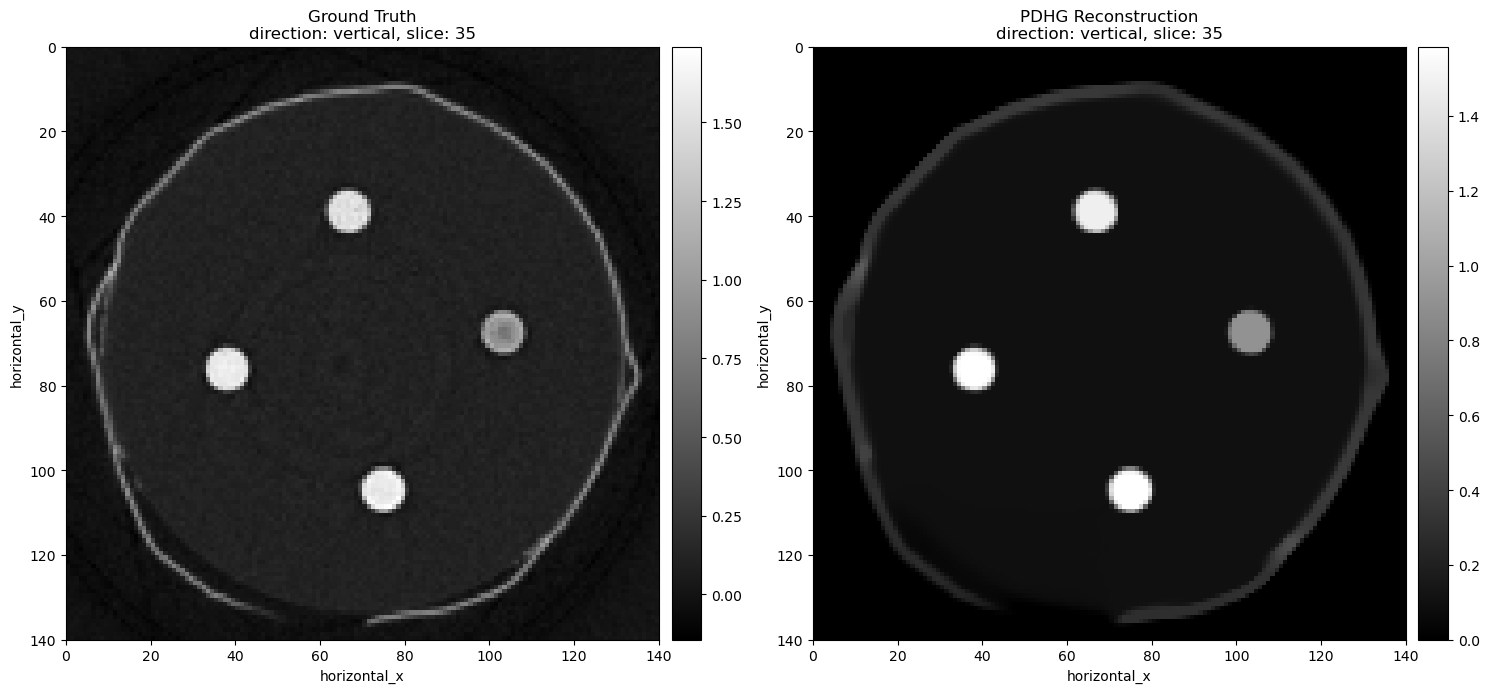

In [ ]:
show2D([reconstruction, pdhg_tv_implicit.solution], title = ['FBP', 'PDHG Reconstruction'], origin = 'upper', num_cols = 2);

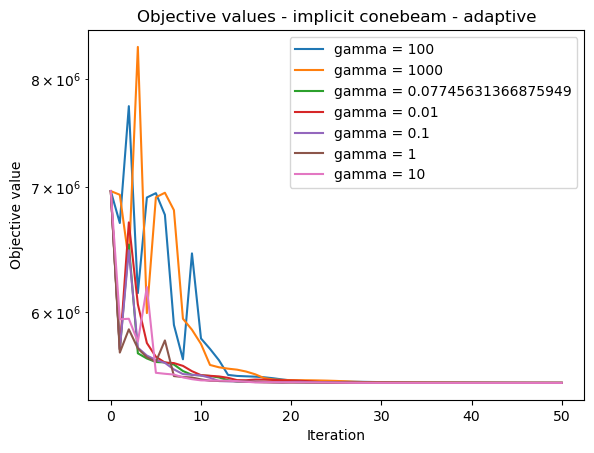

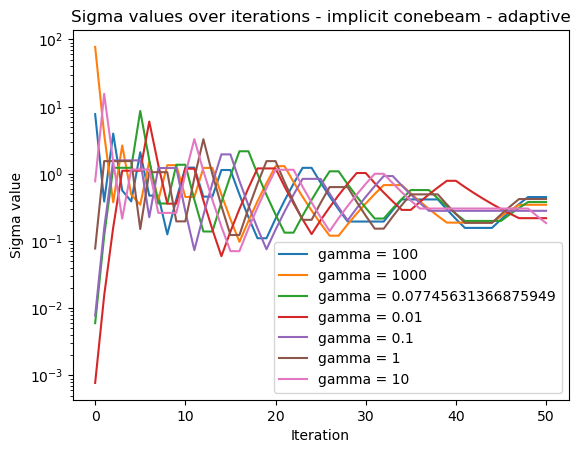

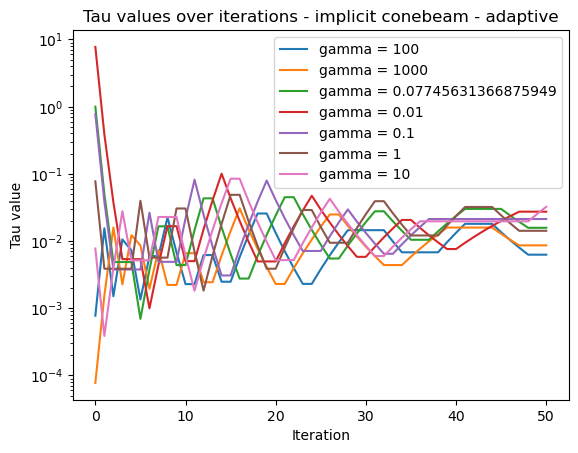

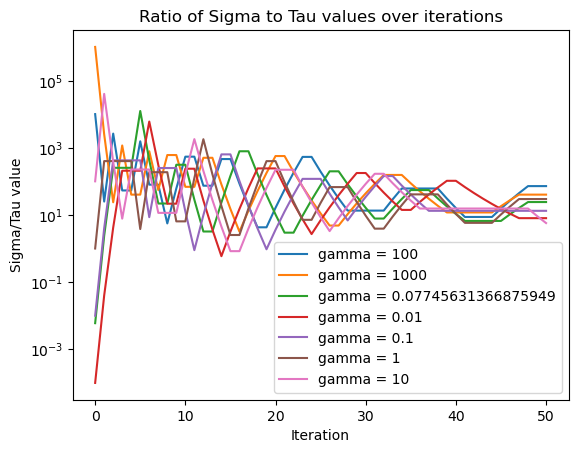

In [19]:
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - implicit conebeam - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma values over iterations - implicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau values over iterations - implicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 51, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values over iterations')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()

In [20]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_implicit.run(50, verbose=1)
    results_vanilla.append(pdhg_tv_implicit.solution)
    objective_vanilla.append(pdhg_tv_implicit.objective)
    

gamma =  0.01
Initial step sizes: tau = 7.7456313668759496, sigma = 0.000774563136687595


  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  122.51987
x norm =  119.66372
x_tmp norm =  129.56558
x norm =  13.2059765
x_tmp norm =  138.73448
x norm =  13.93868
x_tmp norm =  149.8282
x norm =  10.744133
x_tmp norm =  159.62587
x norm =  6.2647715
x_tmp norm =  167.67542
x norm =  3.9252536
x_tmp norm =  175.46037
x norm =  3.3697526
x_tmp norm =  183.67874
x norm =  3.2369313
x_tmp norm =  192.43877
x norm =  3.0969512
x_tmp norm =  201.72058
x norm =  3.027823
x_tmp norm =  211.48897
x norm =  2.9882767
x_tmp norm =  221.69489
x norm =  3.015124
x_tmp norm =  232.30469
x norm =  3.127959
x_tmp norm =  243.29155
x norm =  3.2604375
x_tmp norm =  254.62527
x norm =  3.41653
x_tmp norm =  266.2907
x norm =  4.084625
x_tmp norm =  278.26538
x norm =  4.1362414
x_tmp norm =  290.49496
x norm =  4.107342
x_tmp norm =  302.9707
x norm =  4.164832
x_tmp norm =  315.74567
x norm =  4.8267345
x_tmp norm =  329.1289
x norm =  6.408451
x_tmp norm =  343.7572
x norm =  9.474246
x_tmp norm =  360.3182
x norm =  14.252244
x_tm

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  121.67233
x norm =  118.835976
x_tmp norm =  129.39923
x norm =  13.573141
x_tmp norm =  138.66827
x norm =  19.482414
x_tmp norm =  152.46031
x norm =  24.864002
x_tmp norm =  169.39738
x norm =  28.085722
x_tmp norm =  188.47838
x norm =  30.621275
x_tmp norm =  209.46588
x norm =  32.069504
x_tmp norm =  231.96904
x norm =  31.910507
x_tmp norm =  254.6763
x norm =  30.242823
x_tmp norm =  275.89752
x norm =  27.47911
x_tmp norm =  294.2719
x norm =  24.096428
x_tmp norm =  308.9802
x norm =  20.48258
x_tmp norm =  319.6697
x norm =  16.932346
x_tmp norm =  326.26987
x norm =  13.776917
x_tmp norm =  328.92218
x norm =  11.6286955
x_tmp norm =  327.9676
x norm =  10.92512
x_tmp norm =  323.9072
x norm =  11.547741
x_tmp norm =  317.36646
x norm =  12.818852
x_tmp norm =  309.04706
x norm =  14.042784
x_tmp norm =  299.68866
x norm =  14.780296
x_tmp norm =  290.0022
x norm =  14.924582
x_tmp norm =  280.6074
x norm =  14.535715
x_tmp norm =  272.0347
x norm =  13.56591

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  113.800224
x norm =  113.001686
x_tmp norm =  128.58487
x norm =  26.907074
x_tmp norm =  142.2009
x norm =  30.229155
x_tmp norm =  160.16074
x norm =  29.856752
x_tmp norm =  177.82152
x norm =  28.55
x_tmp norm =  194.17282
x norm =  27.755573
x_tmp norm =  211.25024
x norm =  26.000713
x_tmp norm =  227.94019
x norm =  23.569935
x_tmp norm =  242.87552
x norm =  20.870583
x_tmp norm =  255.3043
x norm =  18.138145
x_tmp norm =  264.9844
x norm =  15.481717
x_tmp norm =  271.94815
x norm =  13.071
x_tmp norm =  276.38123
x norm =  11.142297
x_tmp norm =  278.56204
x norm =  9.762829
x_tmp norm =  278.8271
x norm =  8.854834
x_tmp norm =  277.54013
x norm =  8.272967
x_tmp norm =  275.06985
x norm =  7.892716
x_tmp norm =  271.76382
x norm =  7.6024833
x_tmp norm =  267.92603
x norm =  7.3597207
x_tmp norm =  263.82217
x norm =  7.0915713
x_tmp norm =  259.67773
x norm =  6.810365
x_tmp norm =  255.67737
x norm =  6.5006957
x_tmp norm =  251.96465
x norm =  6.156315
x_t

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  69.095764
x norm =  69.00679
x_tmp norm =  101.23685
x norm =  33.075558
x_tmp norm =  118.01584
x norm =  19.720022
x_tmp norm =  128.49886
x norm =  15.098826
x_tmp norm =  136.31917
x norm =  12.891596
x_tmp norm =  142.82837
x norm =  11.310366
x_tmp norm =  148.50053
x norm =  9.997894
x_tmp norm =  153.55652
x norm =  8.933352
x_tmp norm =  158.12361
x norm =  8.05311
x_tmp norm =  162.31361
x norm =  7.311785
x_tmp norm =  166.18869
x norm =  6.680622
x_tmp norm =  169.79788
x norm =  6.133708
x_tmp norm =  173.17651
x norm =  5.6494055
x_tmp norm =  176.3407
x norm =  5.2249546
x_tmp norm =  179.30753
x norm =  4.853157
x_tmp norm =  182.10362
x norm =  4.5215244
x_tmp norm =  184.74153
x norm =  4.2232375
x_tmp norm =  187.23087
x norm =  3.9528413
x_tmp norm =  189.5798
x norm =  3.707586
x_tmp norm =  191.79697
x norm =  3.4838223
x_tmp norm =  193.8905
x norm =  3.2796497
x_tmp norm =  195.86855
x norm =  3.0926564
x_tmp norm =  197.73882
x norm =  2.9206274
x

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  14.020116
x norm =  14.011003
x_tmp norm =  26.496225
x norm =  12.479102
x_tmp norm =  37.588688
x norm =  11.097613
x_tmp norm =  47.454517
x norm =  9.874282
x_tmp norm =  56.23523
x norm =  8.793871
x_tmp norm =  64.056366
x norm =  7.8405657
x_tmp norm =  71.02908
x norm =  7.0001163
x_tmp norm =  77.25188
x norm =  6.2598734
x_tmp norm =  82.81178
x norm =  5.6086245
x_tmp norm =  87.785934
x norm =  5.0364194
x_tmp norm =  92.24254
x norm =  4.534424
x_tmp norm =  96.24188
x norm =  4.094771
x_tmp norm =  99.83738
x norm =  3.7104485
x_tmp norm =  103.07616
x norm =  3.3751926
x_tmp norm =  106.00001
x norm =  3.08338
x_tmp norm =  108.64568
x norm =  2.8299537
x_tmp norm =  111.04595
x norm =  2.6103482
x_tmp norm =  113.22947
x norm =  2.4204352
x_tmp norm =  115.22166
x norm =  2.2564816
x_tmp norm =  117.04503
x norm =  2.1151092
x_tmp norm =  118.71937
x norm =  1.9932797
x_tmp norm =  120.262146
x norm =  1.8882617
x_tmp norm =  121.68882
x norm =  1.7976241


  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  1.5628409
x norm =  1.5619274
x_tmp norm =  3.105649
x norm =  1.5428206
x_tmp norm =  4.6292057
x norm =  1.5235626
x_tmp norm =  6.1337476
x norm =  1.5045497
x_tmp norm =  7.6195183
x norm =  1.4857821
x_tmp norm =  9.086761
x norm =  1.4672564
x_tmp norm =  10.5357065
x norm =  1.4489702
x_tmp norm =  11.966599
x norm =  1.4309202
x_tmp norm =  13.379667
x norm =  1.4131036
x_tmp norm =  14.775136
x norm =  1.3955163
x_tmp norm =  16.153234
x norm =  1.3781579
x_tmp norm =  17.51419
x norm =  1.3610231
x_tmp norm =  18.858217
x norm =  1.3441094
x_tmp norm =  20.185535
x norm =  1.3274152
x_tmp norm =  21.496357
x norm =  1.3109367
x_tmp norm =  22.790903
x norm =  1.294673
x_tmp norm =  24.069372
x norm =  1.2786189
x_tmp norm =  25.331985
x norm =  1.2627726
x_tmp norm =  26.578928
x norm =  1.247132
x_tmp norm =  27.810413
x norm =  1.2316942
x_tmp norm =  29.026638
x norm =  1.2164565
x_tmp norm =  30.227798
x norm =  1.2014171
x_tmp norm =  31.414087
x norm =  1.

  0%|          | 0/50 [00:00<?, ?it/s]

x_tmp norm =  106.167984
x norm =  105.74815
x_tmp norm =  126.01636
x norm =  28.105265
x_tmp norm =  139.11504
x norm =  27.774326
x_tmp norm =  154.53072
x norm =  26.890047
x_tmp norm =  169.66827
x norm =  24.802095
x_tmp norm =  183.09412
x norm =  23.366697
x_tmp norm =  196.29802
x norm =  21.506485
x_tmp norm =  209.06355
x norm =  19.228014
x_tmp norm =  220.56941
x norm =  16.85243
x_tmp norm =  230.29625
x norm =  14.567655
x_tmp norm =  238.10439
x norm =  12.4608345
x_tmp norm =  244.06282
x norm =  10.572744
x_tmp norm =  248.34724
x norm =  8.971114
x_tmp norm =  251.17827
x norm =  7.6735296
x_tmp norm =  252.7931
x norm =  6.6389847
x_tmp norm =  253.42825
x norm =  5.8060246
x_tmp norm =  253.30867
x norm =  5.1310925
x_tmp norm =  252.6344
x norm =  4.608253
x_tmp norm =  251.57513
x norm =  4.204812
x_tmp norm =  250.27367
x norm =  3.8820355
x_tmp norm =  248.84859
x norm =  3.6012983
x_tmp norm =  247.39426
x norm =  3.3488746
x_tmp norm =  245.98209
x norm =  3.

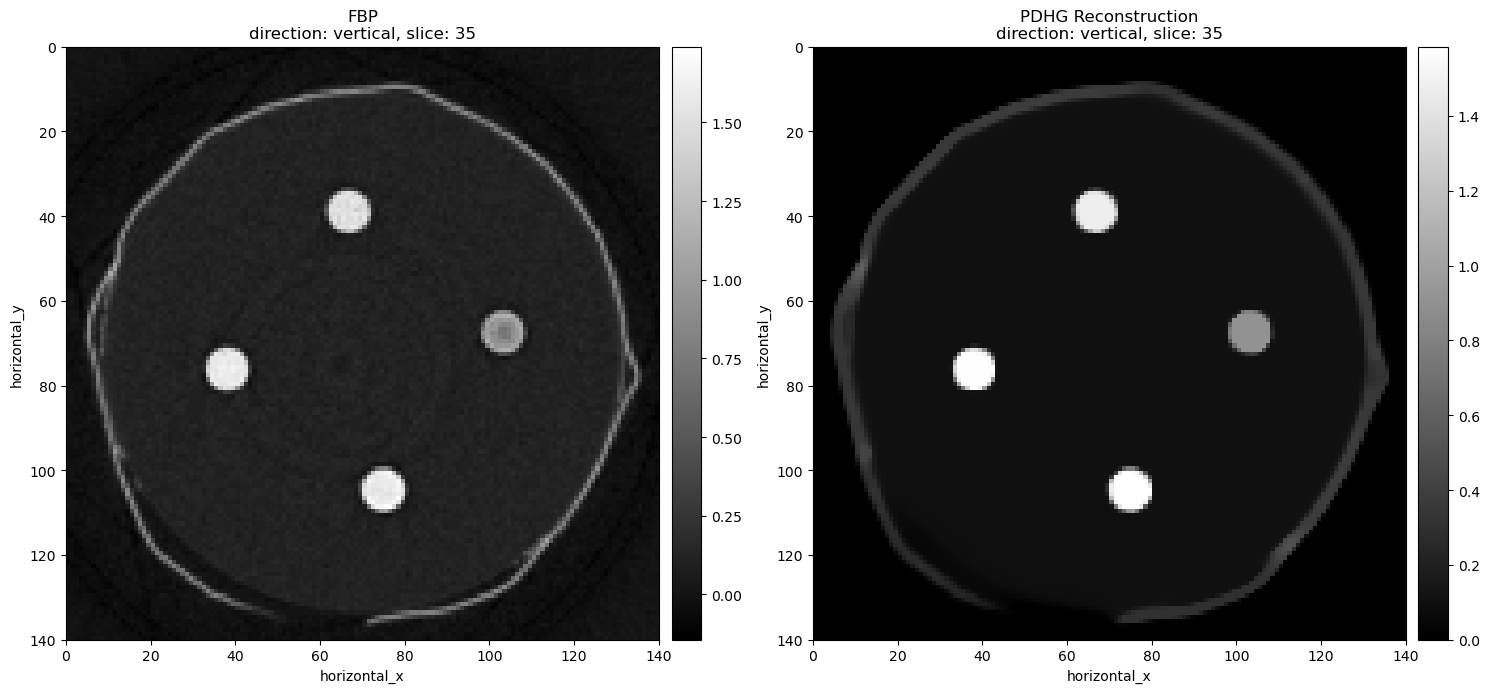

In [21]:
show2D([reconstruction, pdhg_tv_implicit.solution], title = ['FBP', 'PDHG Reconstruction'], origin = 'upper', num_cols = 2);

In [ ]:
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 51, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - implicit conebeam - adaptive vs non-adaptive')
plt.legend()
plt.show()

# PDHG with Explicit TV - adaptive vs non-adaptive

In [ ]:
# Vanilla TV with reg parameter in front of Mixed L21 Norm
alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  alpha *MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad =  GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)



In [ ]:

    
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.title('Vanilla TV')
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


In [ ]:
#   Vanilla TV with reg parameter in front of gradient operator

alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(50, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)
    


In [ ]:

for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


In [ ]:
alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)


gamma_list =  [ 100, 1000,  1/A.norm(), 0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_explicit.run(50, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_explicit.solution)
    objective_adaptive.append(pdhg_tv_explicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

In [ ]:
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit conebeam - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma values - explicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 51, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau values - explicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 51, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values - explicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit conebeam - adaptive vs non-adaptive')
plt.legend()
plt.show()

# Single slice experiments 